<a href="https://colab.research.google.com/github/anoopsanka/retinal_oct/blob/main/notebooks/03c-OCT_PretrainedSimCLR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir ("/content/drive/MyDrive/FourthBrain/Capstone Samsung OCT/Data/OCT2017")

Mounted at /content/drive


In [3]:
seed = 42
val_split   = 0.02
train_split = 1 - val_split
batch_size = 32
IMG_SIZE=224

ds_val = tf.keras.preprocessing.image_dataset_from_directory(
    'train',
    labels="inferred",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(224, 224),
    shuffle=True,
    seed=seed,
    validation_split=val_split,
    subset='validation',
    interpolation="bilinear",
    follow_links=False,
    )
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    'train',
    labels="inferred",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(224, 224),
    shuffle=True,
    seed=seed,
    validation_split=val_split,
    subset='training',
    interpolation="bilinear",
    follow_links=False,
    )

ds_test = tf.keras.preprocessing.image_dataset_from_directory(
    'test',
    labels="inferred",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(224, 224),
    shuffle=True,
    seed=seed,
    interpolation="bilinear",
    follow_links=False,
    )

Found 46279 files belonging to 4 classes.
Using 925 files for validation.
Found 83484 files belonging to 4 classes.
Using 81815 files for training.
Found 968 files belonging to 4 classes.


# Feature Extraction with Pretrained SimCLR
- Ultimately we want to train a SimCLR model with the wealth of OCT images
- as a zeroth step, we ask how well are SimCLR pretrained on ImageNet works on the unseen OCT images domain.
- we use SimCLR as a feature extractor and try to see how well a simple linear classification head (multi-class logistic regression) works in terms of distinguiishing between classes


In [4]:
#@title Load module and construct the computation graph
import tensorflow_hub as hub
import tensorflow as tf
# Load the base network and set it to non-trainable (for speedup fine-tuning)
hub_path = 'gs://simclr-checkpoints/simclrv2/finetuned_100pct/r50_1x_sk0/hub/'
#hub_path = 'gs://simclr-checkpoints/simclrv2/finetuned_100pct/r101_2x_sk1/hub'

In [25]:
input_layer  = tf.keras.layers.Input((224,224,3))
simclr_layer = hub.KerasLayer(hub_path, trainable=False,)
classification_head = tf.keras.layers.Dense(4, activation='softmax')


model = tf.keras.Sequential([input_layer, 
                             simclr_layer,
                             classification_head])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              34277672  
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 8196      
Total params: 34,285,868
Trainable params: 8,196
Non-trainable params: 34,277,672
_________________________________________________________________


In [6]:
metrics = ['accuracy']
callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', ),
             tf.keras.callbacks.ModelCheckpoint(filepath='resnet_model.{epoch:02d}-{val_loss:.2f}.h5'),]
optimizer = tf.keras.optimizers.Adam(lr=1e-3)
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=metrics)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [7]:
import os

# simple version for working with CWD
nCNV = len([name for name in os.listdir('train/CNV')])
nDME = len([name for name in os.listdir('train/DME')])
nDRUSEN = len([name for name in os.listdir('train/DRUSEN')])
nNORMAL = len([name for name in os.listdir('train/NORMAL')])

ncount = np.array([nCNV, nDME, nDRUSEN, nNORMAL])
ntotal = sum(ncount)

weights = ntotal/ncount/ len(ncount)
weights /= weights.min()
class_weight = {i: w for i, w in enumerate(weights)}

# Retrieve the Representation
- we run our examples through the SimCLR to retrieve the embedding as seen by the nerual network


In [8]:
def get_representation(dataset, max_batch=500):
  out_rep, out_label = [], []
  count = 0
  for img, lb in dataset:
    out_rep.append(simclr_layer(img).numpy())
    out_label.append(lb.numpy())
    if count % 100 == 0: print(f'count = {count}')
    if count > max_batch: break
    count += 1
  out_label = np.hstack(out_label)
  out_rep   = np.vstack(out_rep)
  return out_rep, out_label

In [9]:
type(ds_test)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [10]:
# train_rep, train_lb = get_representation(ds_train)
test_rep,  test_lb = get_representation(ds_test)

count = 0


In [11]:
train_rep, train_lb = get_representation(ds_train)

count = 0
count = 100
count = 200
count = 300
count = 400
count = 500


In [12]:
train_rep = train_rep / np.sqrt(np.square(train_rep).mean(axis=-1, keepdims=True))
test_rep  = test_rep  / np.sqrt(np.square(test_rep).mean(axis=-1, keepdims=True))

In [13]:
train_rep.shape

(16064, 2048)

In [14]:
import os

# simple version for working with CWD
nCNV = len([name for name in os.listdir('train/CNV')])
nDME = len([name for name in os.listdir('train/DME')])
nDRUSEN = len([name for name in os.listdir('train/DRUSEN')])
nNORMAL = len([name for name in os.listdir('train/NORMAL')])

ncount = np.array([nCNV, nDME, nDRUSEN, nNORMAL])
ntotal = sum(ncount)

weights = ntotal/ncount/ len(ncount)
weights /= weights.min()
class_weight = {i: w for i, w in enumerate(weights)}

# Fitting a Linear Regression Model
- attach a dense layer with 4 outputs with softmax activation
- minimize the cross-entropy taking into the account of the inherent imbalance between the 4 classes

In [17]:
learning_rate = 1.0e-3


linearRegression = tf.keras.Sequential([tf.keras.layers.Input(2048),
                                       tf.keras.layers.Dense(4, activation='softmax')])

optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
linearRegression.compile(loss='sparse_categorical_crossentropy', 
                         metrics='accuracy', 
                         optimizer=optimizer)

In [18]:
history = linearRegression.fit(train_rep, 
                              train_lb, 
                              batch_size=32, 
                              epochs=100,
                              class_weight=class_weight,
                              validation_data=(test_rep, test_lb),)

Epoch 1/100
502/502 [==============================] - 2s 3ms/step - loss: 2.3957 - accuracy: 0.3780 - val_loss: 1.1691 - val_accuracy: 0.4721
Epoch 2/100
502/502 [==============================] - 1s 3ms/step - loss: 2.2041 - accuracy: 0.4798 - val_loss: 1.0703 - val_accuracy: 0.5682
Epoch 3/100
502/502 [==============================] - 1s 2ms/step - loss: 2.1084 - accuracy: 0.5163 - val_loss: 1.0222 - val_accuracy: 0.6105
Epoch 4/100
502/502 [==============================] - 1s 2ms/step - loss: 2.0353 - accuracy: 0.5429 - val_loss: 0.9553 - val_accuracy: 0.6715
Epoch 5/100
502/502 [==============================] - 1s 3ms/step - loss: 1.9788 - accuracy: 0.5575 - val_loss: 0.9285 - val_accuracy: 0.6581
Epoch 6/100
502/502 [==============================] - 1s 3ms/step - loss: 1.9410 - accuracy: 0.5744 - val_loss: 0.9376 - val_accuracy: 0.6271
Epoch 7/100
502/502 [==============================] - 1s 3ms/step - loss: 1.9016 - accuracy: 0.5832 - val_loss: 0.9409 - val_accuracy: 0.6074

In [19]:
history = linearRegression.fit(train_rep, 
                               train_lb, 
                               batch_size=32, 
                               epochs=400,
                               class_weight=class_weight,
                               validation_data=(test_rep, test_lb),
                               initial_epoch=100)

Epoch 101/400
502/502 [==============================] - 1s 3ms/step - loss: 1.4308 - accuracy: 0.7015 - val_loss: 0.6162 - val_accuracy: 0.7665
Epoch 102/400
502/502 [==============================] - 1s 3ms/step - loss: 1.4303 - accuracy: 0.7032 - val_loss: 0.6629 - val_accuracy: 0.7242
Epoch 103/400
502/502 [==============================] - 1s 2ms/step - loss: 1.4324 - accuracy: 0.7026 - val_loss: 0.5899 - val_accuracy: 0.7810
Epoch 104/400
502/502 [==============================] - 1s 2ms/step - loss: 1.4319 - accuracy: 0.7021 - val_loss: 0.5960 - val_accuracy: 0.7696
Epoch 105/400
502/502 [==============================] - 1s 3ms/step - loss: 1.4307 - accuracy: 0.7009 - val_loss: 0.5746 - val_accuracy: 0.7893
Epoch 106/400
502/502 [==============================] - 1s 2ms/step - loss: 1.4238 - accuracy: 0.7034 - val_loss: 0.5797 - val_accuracy: 0.7769
Epoch 107/400
502/502 [==============================] - 1s 3ms/step - loss: 1.4238 - accuracy: 0.7072 - val_loss: 0.5844 - val_ac

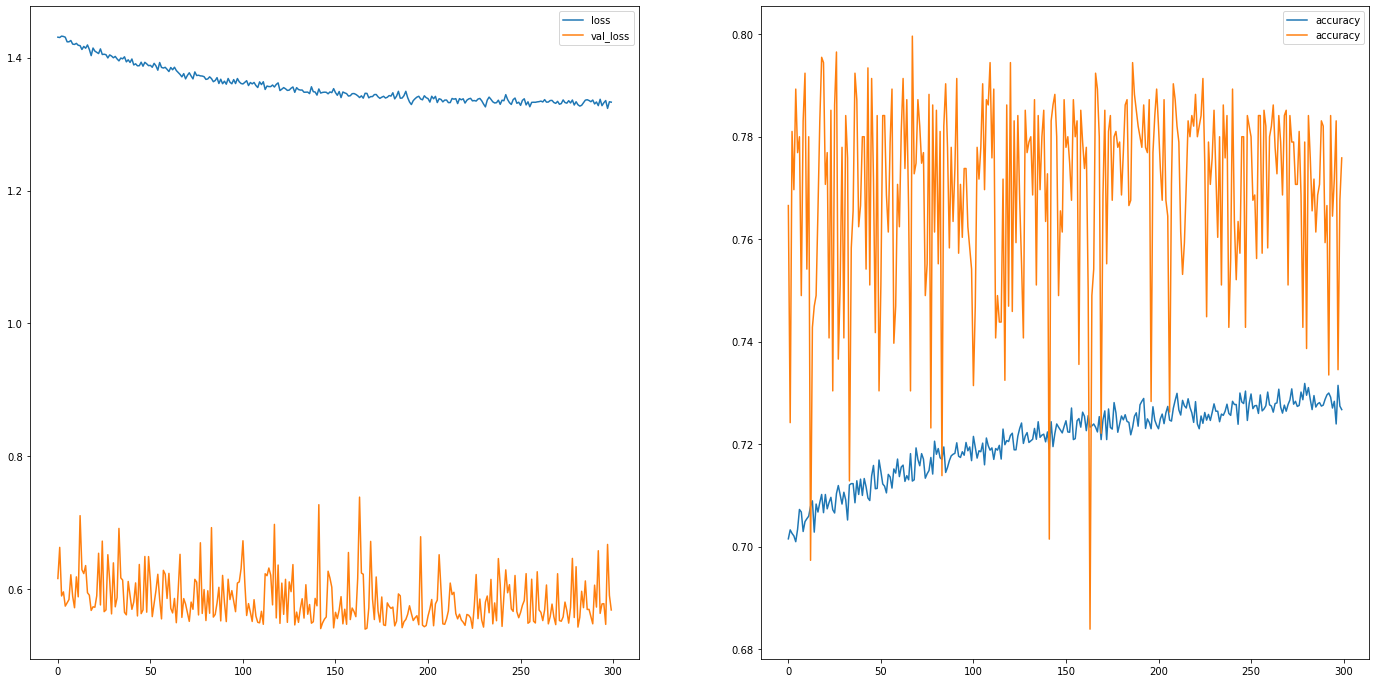

In [20]:
f = plt.figure(figsize=(24,12))
ax1 = f.add_subplot(1,2,1)
ax1.plot(linearRegression.history.history['loss'], label="loss")
ax1.plot(linearRegression.history.history['val_loss'], label="val_loss")
ax1.legend()

ax2 = f.add_subplot(1,2,2)
ax2.plot(linearRegression.history.history['accuracy'], label="accuracy")
ax2.plot(linearRegression.history.history['val_accuracy'], label="accuracy")
ax2.legend()

In [21]:
ypred_train = linearRegression(train_rep).numpy().argmax(axis=-1)
ypred_test  = linearRegression(test_rep).numpy().argmax(axis=-1)

In [22]:
from sklearn.metrics import classification_report

In [23]:
print(classification_report(train_lb, ypred_train))

              precision    recall  f1-score   support

           0       0.91      0.80      0.85      7157
           1       0.51      0.82      0.63      2189
           2       0.36      0.65      0.46      1624
           3       0.87      0.57      0.69      5094

    accuracy                           0.72     16064
   macro avg       0.66      0.71      0.66     16064
weighted avg       0.79      0.72      0.73     16064



In [24]:
print(classification_report(test_lb, ypred_test))

              precision    recall  f1-score   support

           0       0.83      0.88      0.86       242
           1       0.75      0.83      0.79       242
           2       0.69      0.66      0.68       242
           3       0.83      0.73      0.78       242

    accuracy                           0.78       968
   macro avg       0.78      0.78      0.77       968
weighted avg       0.78      0.78      0.77       968



# NOT BAD!!
- with only a linear regression, we achieve an overall accuracy of 65%, as opposed to a completely random guess with gives 25 %!
- a good baseline on a SimCLR trained on the actual image distribution! 

In [ ]:
# http://karpathy.github.io/2019/04/25/recipe/#2-set-up-the-end-to-end-trainingevaluation-skeleton--get-dumb-baselines
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#optional_set_the_correct_initial_bias